# **1. Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

# **2. Membaca data file CSV**

In [ ]:
#menghubungkan colab dengan google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Machine Learning/Pertemuan4/Praktikum/data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


# **3. Melihat informasi umum dataset**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


# **4. Data Pre-processing**

**4.1 Cek Missing Value**

In [ ]:
# cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


**4.2 Cek Nilai Unik**

In [ ]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [ ]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

**4.3 Mapping Kolom Kategorik ke Bentuk Numerik**

In [ ]:
# 1. Mapping kolom Stunting -> biner
map_stunt = {'Stunted': 1, 'Several Stunted': 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).fillna(0).astype('int64')

# 2. Mapping kolom Jenis Kelamin -> biner
# Laki-laki = 1, Perempuan = 0
df['JK_bin'] = (df['Jenis Kelamin'].str.strip() == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    83840
1    16160
Name: count, dtype: int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


**4.4 Analisis Korelasi Antar Variabel Numerik**

In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.063089,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.191702,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.039054,0.045797
Stunting_bin,0.063089,-0.191702,0.039054,1.000000,-0.009994
JK_bin,0.004046,0.073505,0.045797,-0.009994,1.000000


**4.5 Visualisasi Heatmap Korelasi**

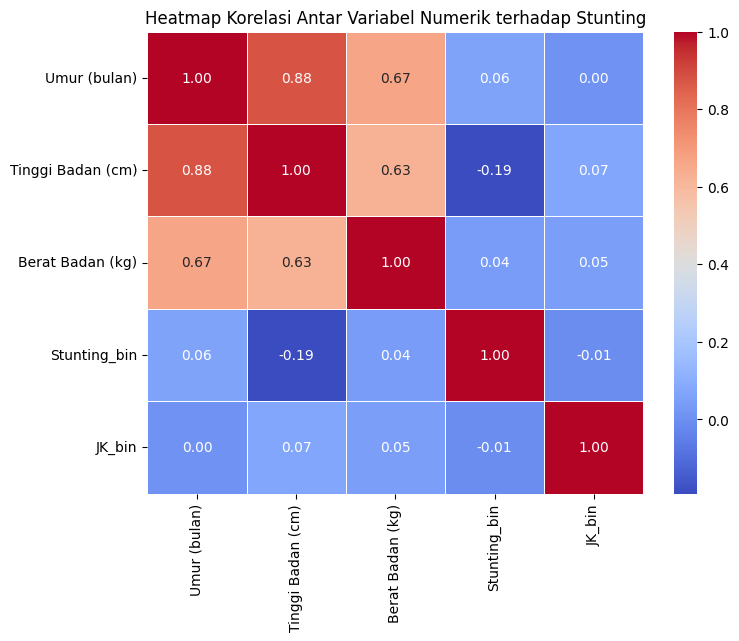

In [ ]:
# Visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting",  fontsize=12)
plt.show()

# **5. Pembagian Dataset (Training dan Testing)**

**5.1 Menentukan Fitur dan Target**

In [ ]:
# Fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_use = df[use_cols].dropna().copy()
df_model = df_use.copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (100000, 4)
y shape: (100000,)


**5.2 Membagi Dataset menjadi Training dan Testing Set**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Data latih:", X_train.shape)
print("Data uji:", X_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


# **6. Pembangunan Model Logistic Regression**

In [ ]:
# Scale hanya fitur numerik, gender langsung passtrought
preprocess = ColumnTransformer(
    transformers=[
    ('num', StandardScaler(), feature_num),
    ('bin', 'passthrough', feature_bin)
  ],
  remainder='drop'
)

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

# Latihan model
clf.fit(X_train, y_train)
print("✅ Model Logistic Regression berhasil dilatih")

✅ Model Logistic Regression berhasil dilatih


# **7. Prediksi Model dan Evaluasi Model**

In [ ]:
# Prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Hitung metrik
print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

Akurasi: 0.8375
Precision: 0.4984
Recall: 0.9415
F1 Score: 0.6518
ROC AUC: 0.9089


# **8. Visualisasi Hasil Evaluasi**

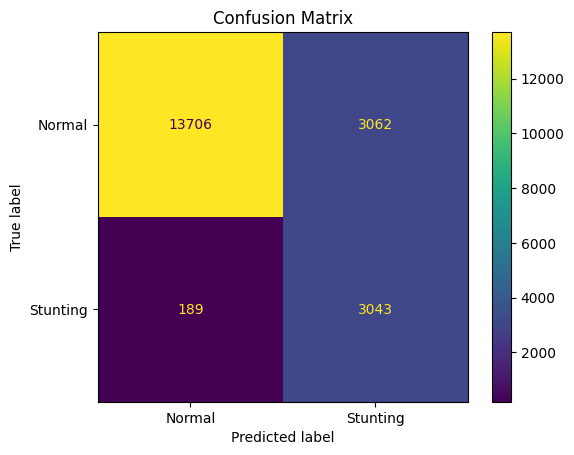

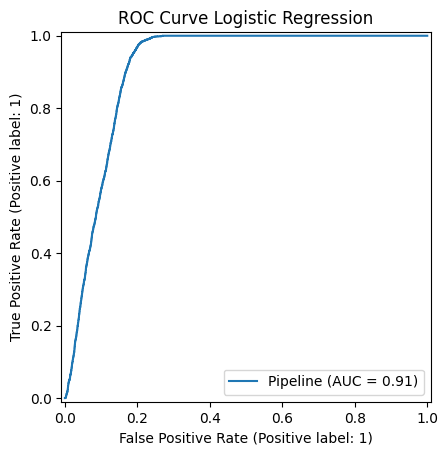

In [ ]:
# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']
                      ).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()


# **9. Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.82      0.89     16768
      Stunting (1)       0.50      0.94      0.65      3232

          accuracy                           0.84     20000
         macro avg       0.74      0.88      0.77     20000
      weighted avg       0.91      0.84      0.85     20000



# **10. Classification Report**

In [ ]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

#Tampilkan hasil
print("Skor tiap fold:", scores)
print("Rata-rata akurasi:", np.mean(scores))
print("Standar deviasi:", np.std(scores))

Skor tiap fold: [0.84445 0.8371  0.84395 0.83685 0.8388 ]
Rata-rata akurasi: 0.84023
Standar deviasi: 0.0033140006035002633


# **11. Interpretasi Model Logistic Regression**

In [ ]:
# Ambil nama fitur & koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Feature': feat_names,
    'Koefisien (log_odds)': coefs,
    'Odds Ratio (e^coef)': odds
}).sort_values(by='Odds Ratio (e^coef)', ascending=False)

display(coef_df)

,Feature,Koefisien (log_odds),Odds Ratio (e^coef)
0,Umur (bulan),5.286914,197.732368
3,JK_bin,0.976383,2.654838
2,Berat Badan (kg),0.429383,1.536309
1,Tinggi Badan (cm),-6.487278,0.001523


# **12. Prediksi Data Baru (Contoh Kasus)**

In [ ]:
# Contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.982239,1
1,10,72.5,7.8,0,0.023713,0
